https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet-yt

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true:list, y_pred:list):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [5]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


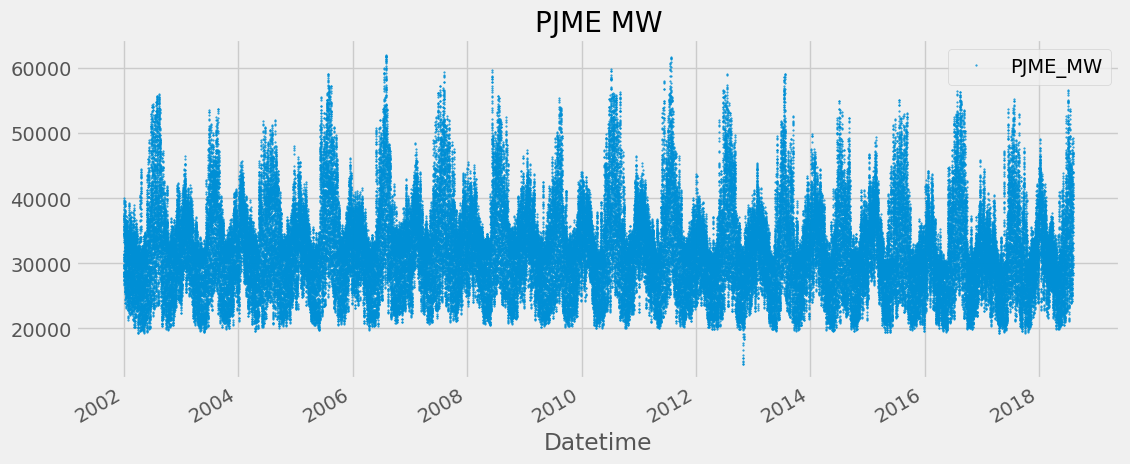

In [6]:
color_pal = sns.color_palette()
pjme.plot(style = '.',
          figsize=(12,5),
          ms = 1,
          color = color_pal[0],
          title='PJME MW')
plt.show()

In [7]:
# Time Series Features

In [9]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
#    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [11]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


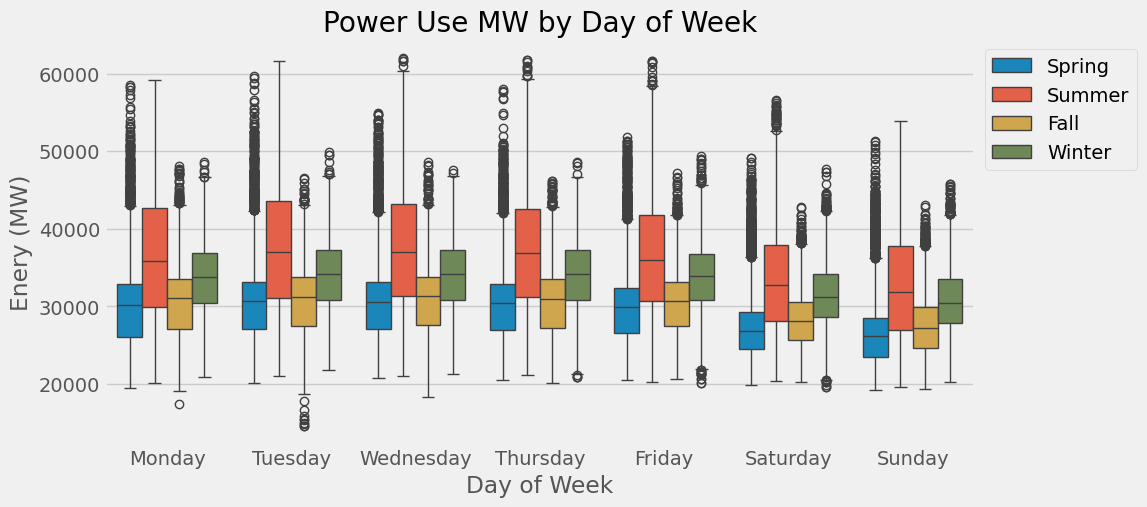

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x = 'weekday',
            y = 'PJME_MW',
            hue = 'season',
            ax = ax,
            linewidth = 1)

plt.title('Power Use MW by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Enery (MW)')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

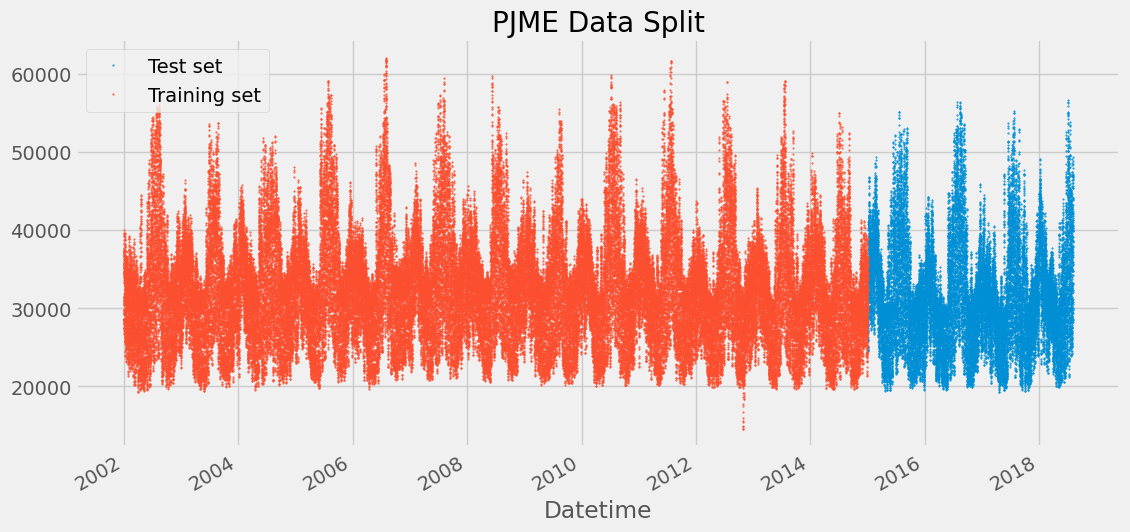

In [17]:
# Train Test Split

split_date = '01-01-2015'
pjme_train = pjme.loc[pjme.index < split_date].copy()
pjme_test = pjme.loc[pjme.index >= split_date].copy()

pjme_test \
.rename(columns={'PJME_MW': 'Test set'}) \
.join(pjme_train.rename(columns={'PJME_MW': 'Training set'}),
      how = 'outer') \
.plot(figsize=(12,6), title='PJME Data Split', style = '.', ms=1)
plt.legend()

plt.show()

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

Datetime column: ds
target: y

In [18]:
pjme_train_prophet = pjme_train.reset_index() \
                        .rename(columns={'Datetime': 'ds',
                                         'PJME_MW': 'y'})

In [19]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [21]:
%%time
print('hwllo')

hwllo
CPU times: total: 0 ns
Wall time: 1 ms


In [22]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

16:44:27 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 11.6 s
Wall time: 1min 43s


In [25]:
# Predict on test set
pjme_test_prophet = pjme_test.reset_index() \
                    .rename(columns={'Datetime': 'ds',
                                     'PJME_MW': 'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [26]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31198.067010,26009.185654,35262.838825,31198.067010,31198.067010,-822.338463,-822.338463,-822.338463,-2412.313680,...,1288.700182,1288.700182,1288.700182,301.275034,301.275034,301.275034,0.0,0.0,0.0,30375.728546
1,2015-01-01 01:00:00,31198.028494,23889.327788,33108.340624,31198.028494,31198.028494,-2846.723576,-2846.723576,-2846.723576,-4430.512069,...,1281.258842,1281.258842,1281.258842,302.529650,302.529650,302.529650,0.0,0.0,0.0,28351.304918
2,2015-01-01 02:00:00,31197.989978,22442.247865,31565.084504,31197.989978,31197.989978,-4351.021190,-4351.021190,-4351.021190,-5927.351113,...,1272.504173,1272.504173,1272.504173,303.825750,303.825750,303.825750,0.0,0.0,0.0,26846.968788
3,2015-01-01 03:00:00,31197.951463,21445.372010,30573.645235,31197.951463,31197.951463,-5222.632872,-5222.632872,-5222.632872,-6790.340644,...,1262.544409,1262.544409,1262.544409,305.163363,305.163363,305.163363,0.0,0.0,0.0,25975.318591
4,2015-01-01 04:00:00,31197.912947,21259.245895,30631.864950,31197.912947,31197.912947,-5364.138779,-5364.138779,-5364.138779,-6922.184420,...,1251.503128,1251.503128,1251.503128,306.542514,306.542514,306.542514,0.0,0.0,0.0,25833.774168


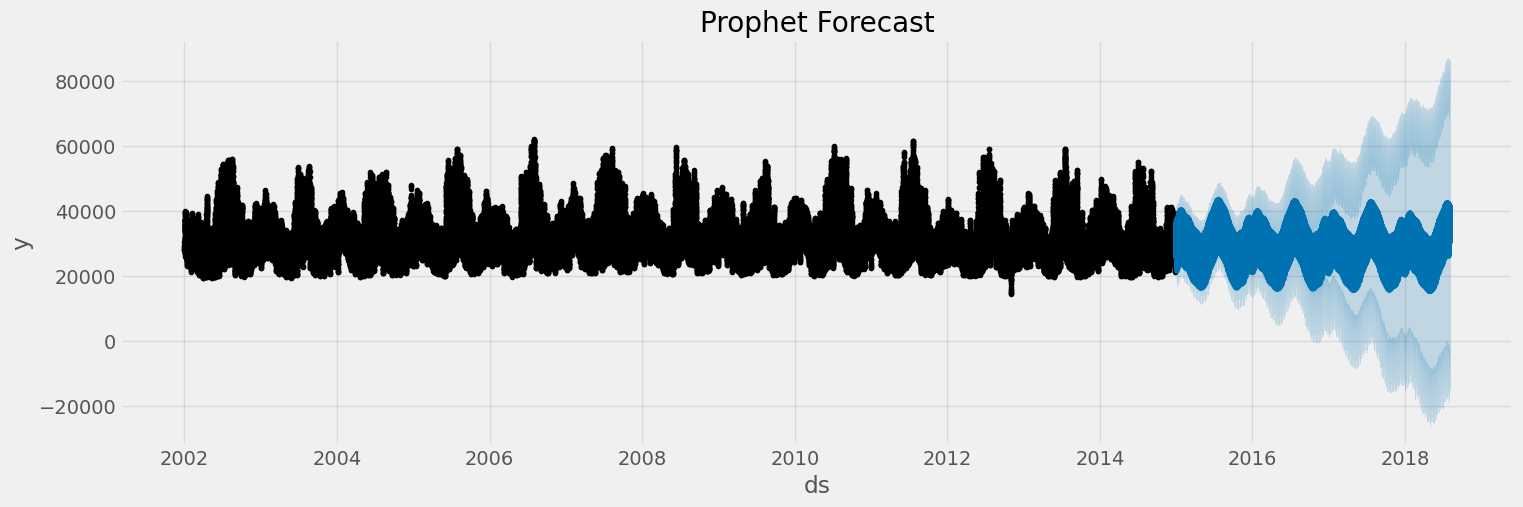

In [29]:
fig, ax = plt.subplots(figsize=(16,5))
fig = model.plot(pjme_test_fcst, ax = ax)
ax.set_title('Prophet Forecast')
plt.show()

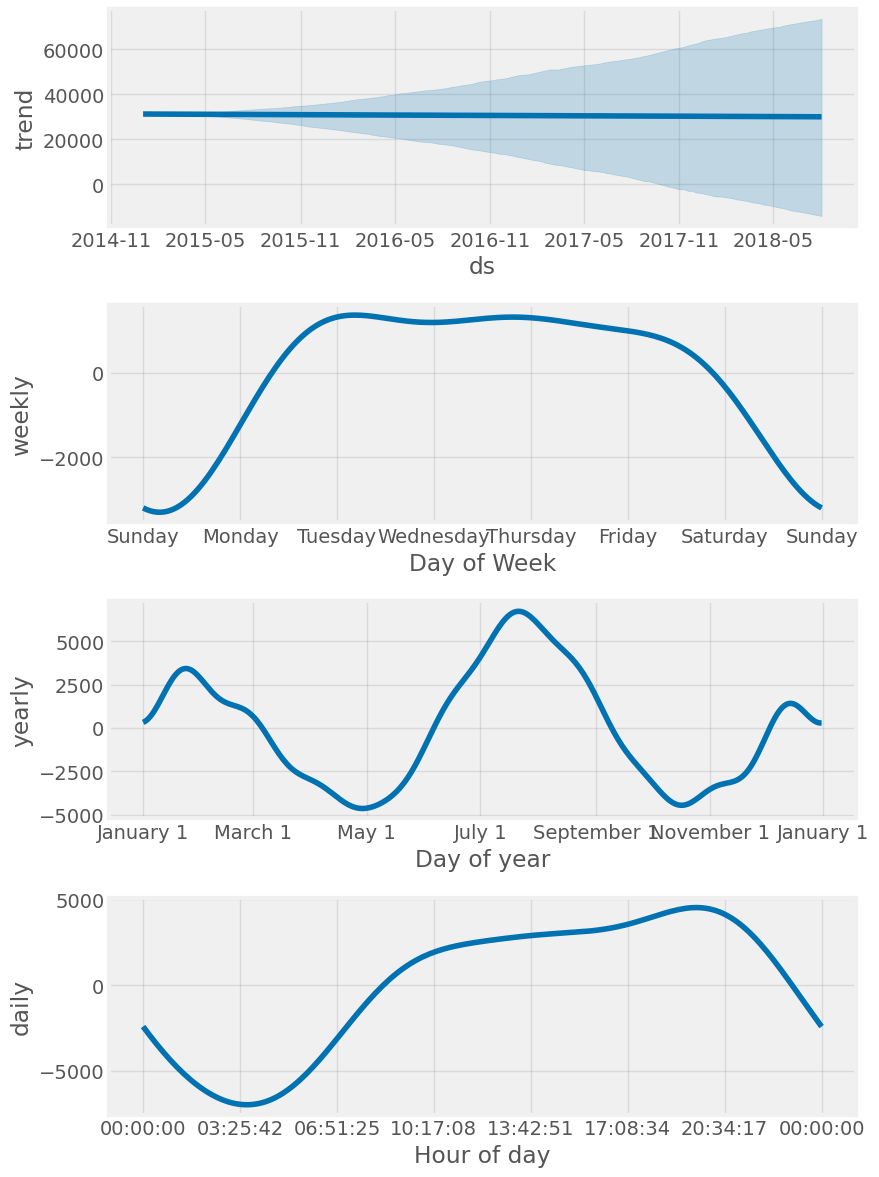

In [30]:
model.plot_components(pjme_test_fcst)
plt.show()

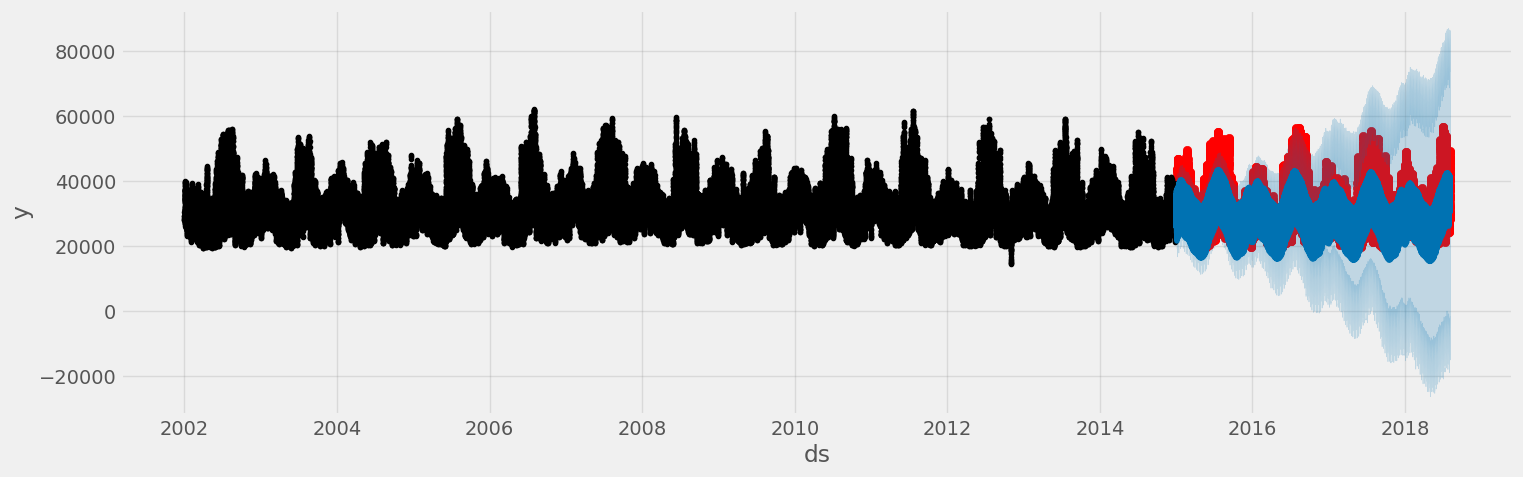

In [50]:
# Compare Forecast to Actuals

fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax = ax)
#ax.set_xbound(lower = '01-01-2015', upper = '02-01-2015')
#plt.xlim([pd.to_datetime('2015-06-01'), pd.to_datetime('2015-06-09')]) 

plt.show()

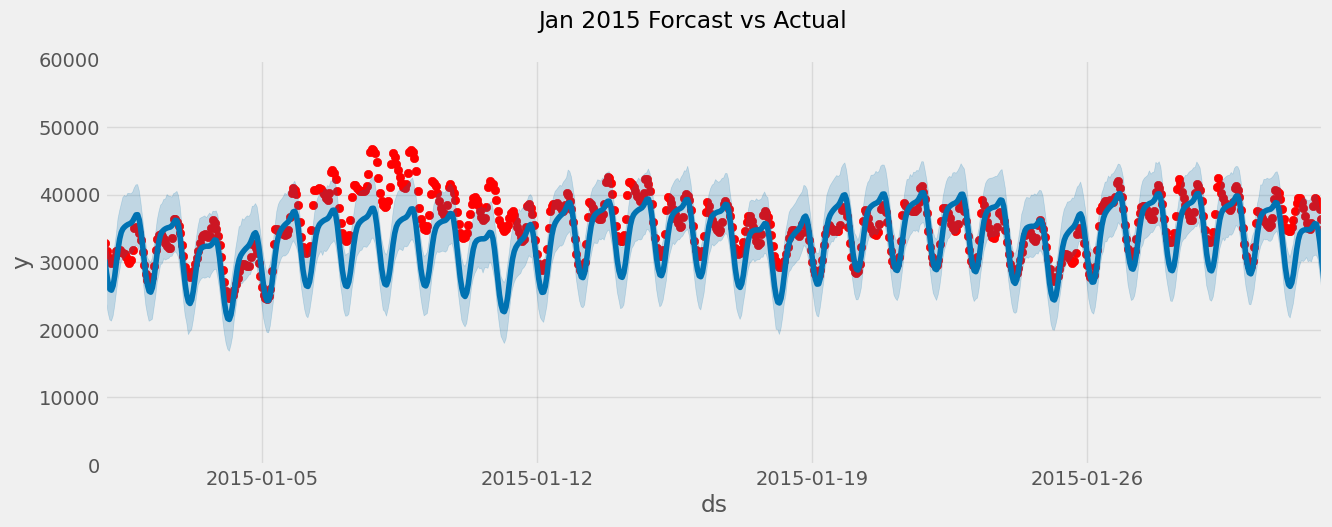

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax = ax)

ax.set_xbound(lower = pd.to_datetime('01-01-2015'),
              upper = pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Jan 2015 Forcast vs Actual')

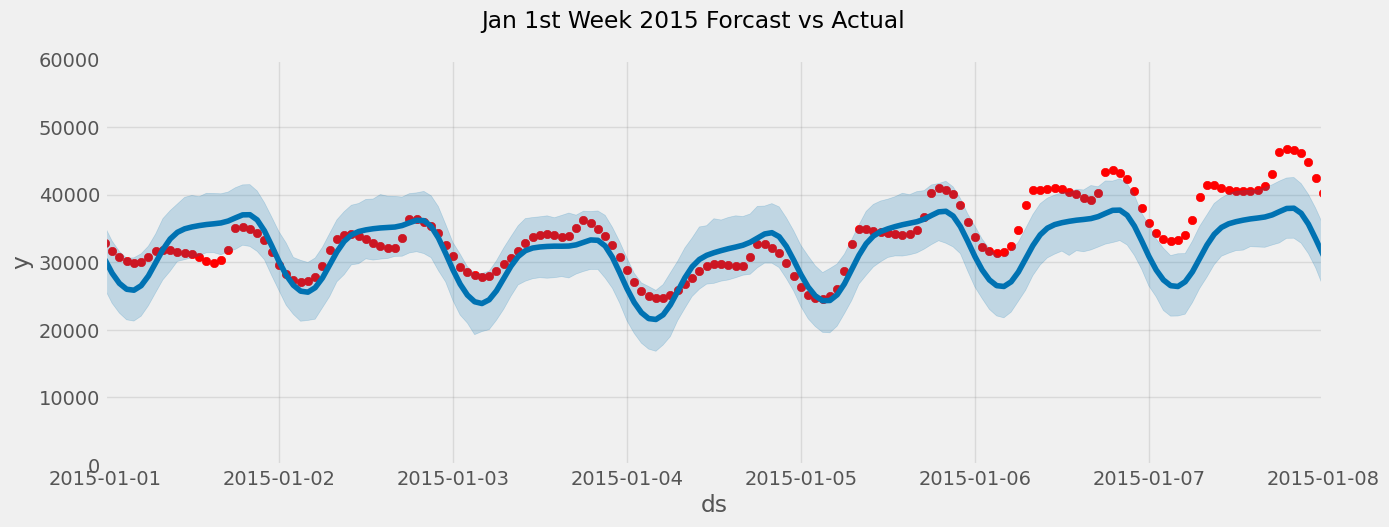

In [53]:
fig, ax = plt.subplots(figsize=(14,5))

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax = ax)

ax.set_xbound(lower = pd.to_datetime('01-01-2015'),
              upper = pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)

#plot = plt.suptitle('Jan 2015 Forcast vs Actual')
plot = plt.suptitle('Jan 1st Week 2015 Forcast vs Actual')

In [54]:
score = np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                                   y_pred = pjme_test_fcst['yhat']))
score

6619.30460545192

In [55]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                   y_pred = pjme_test_fcst['yhat'])

5183.4309679102025

In [56]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.505150835690497

In [57]:
# Adding Holidays

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

holidays = cal.holidays(start = pjme.index.min(),
                        end = pjme.index.max(),
                        return_name=True)

holiday_df = pd.DataFrame(data = holidays,
                          columns = ['holiday'])

holiday_df = holiday_df.reset_index().rename(columns = {'index': 'ds'})

In [70]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:16:19 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 13.5 s
Wall time: 2min 17s


In [71]:
pjme_test_fcst_with_holidays = model_with_holidays.predict(pjme_test_prophet)

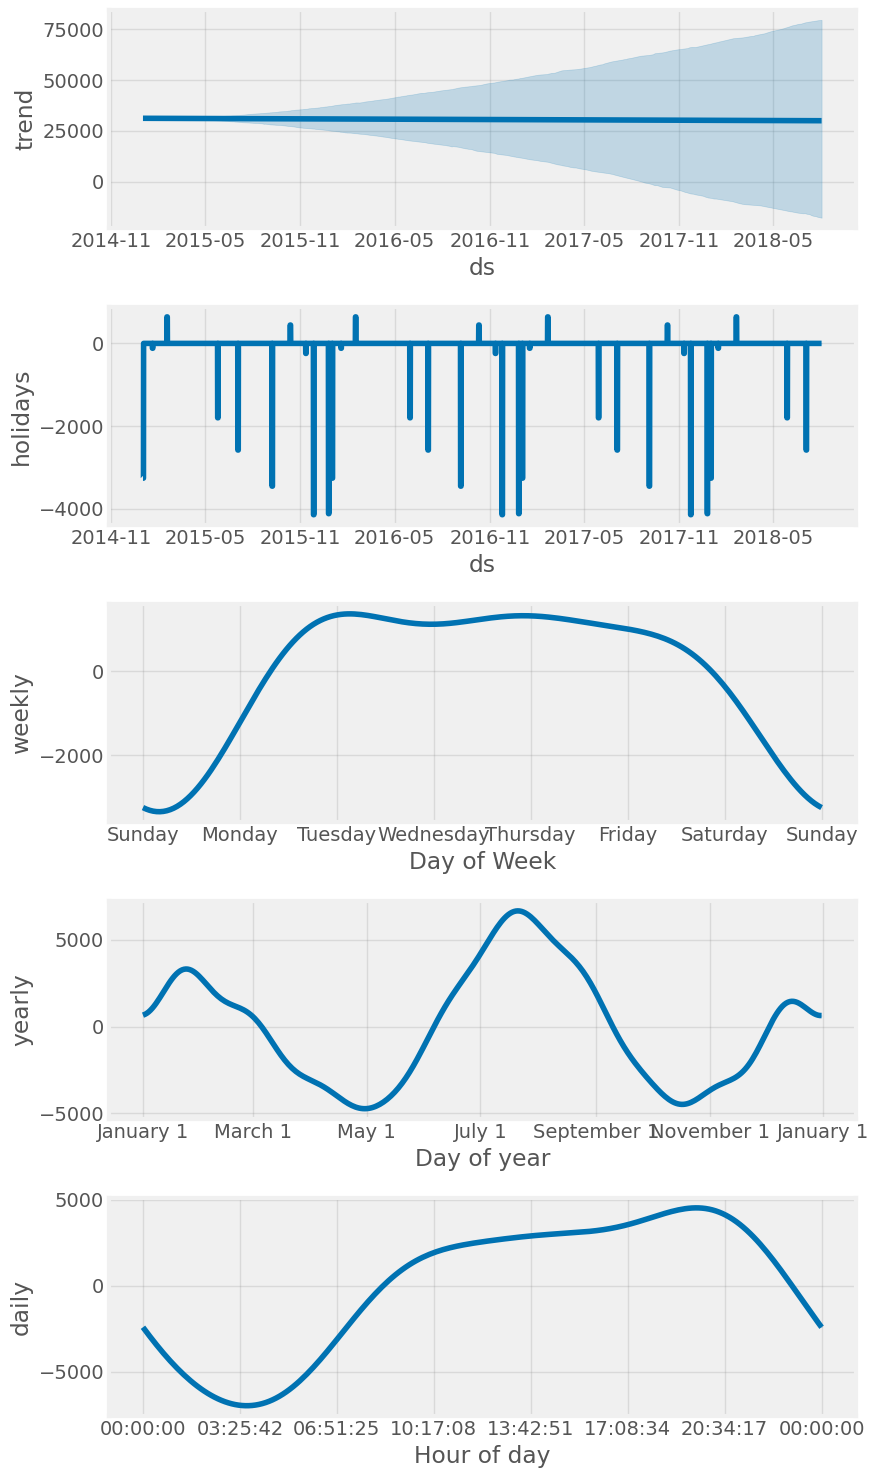

In [74]:
model_with_holidays.plot_components(pjme_test_fcst_with_holidays)
plt.show()

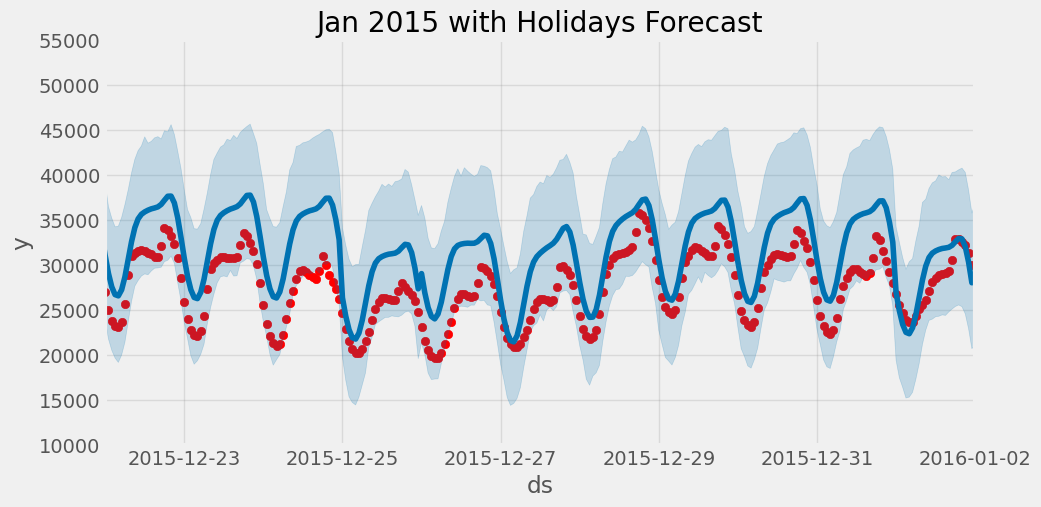

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color = 'r')
fig = model_with_holidays.plot(pjme_test_fcst_with_holidays, ax = ax)
ax.set_xbound(lower = pd.to_datetime('12-22-2015'),
              upper = pd.to_datetime('01-02-2016'))
ax.set_ylim(10000,55000)
plt.title('Jan 2015 with Holidays Forecast')
plt.show()

In [84]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [85]:
future.head()

,ds
0,2015-01-01 00:00:00
1,2015-01-01 01:00:00
2,2015-01-01 02:00:00
3,2015-01-01 03:00:00
4,2015-01-01 04:00:00


In [86]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31253.750291,23356.247435,32295.470006,31253.750291,31253.750291,0.0,0.0,0.0,0.0,...,1328.407025,1328.407025,1328.407025,645.988024,645.988024,645.988024,0.0,0.0,0.0,27554.218161
1,2015-01-01 01:00:00,31253.712288,21028.538296,30105.682280,31253.712288,31253.712288,0.0,0.0,0.0,0.0,...,1324.272806,1324.272806,1324.272806,646.896638,646.896638,646.896638,0.0,0.0,0.0,25532.703817
2,2015-01-01 02:00:00,31253.674285,19744.861370,28448.423875,31253.674285,31253.674285,0.0,0.0,0.0,0.0,...,1318.507202,1318.507202,1318.507202,647.839028,647.839028,647.839028,0.0,0.0,0.0,24030.943053
3,2015-01-01 03:00:00,31253.636282,18605.032980,27744.351523,31253.636282,31253.636282,0.0,0.0,0.0,0.0,...,1311.201946,1311.201946,1311.201946,648.815234,648.815234,648.815234,0.0,0.0,0.0,23161.559193
4,2015-01-01 04:00:00,31253.598279,18700.914666,27780.542110,31253.598279,31253.598279,0.0,0.0,0.0,0.0,...,1302.467743,1302.467743,1302.467743,649.825295,649.825295,649.825295,0.0,0.0,0.0,23021.975956


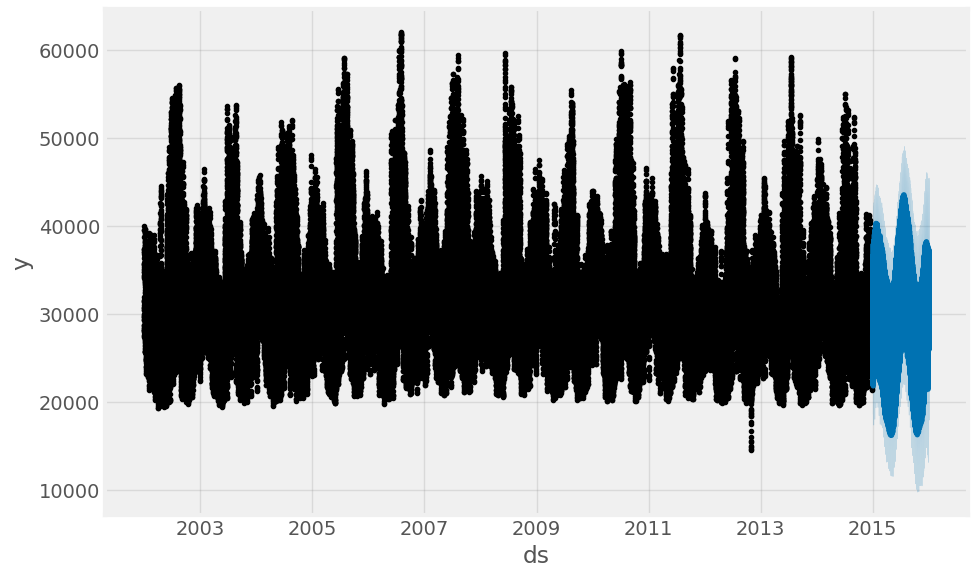

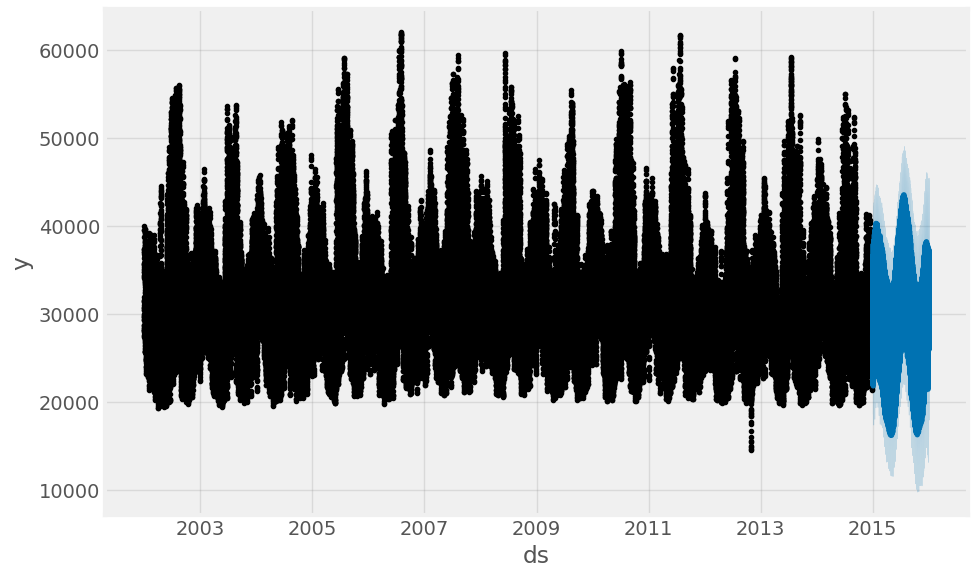

In [87]:
model_with_holidays.plot(forecast)